In [ ]:
from zipfile import ZipFile

# as colab takes forever to upload the large folder, so better to upload the zip file then extract
with ZipFile("sample_cropped.zip", 'r') as zObject:

	zObject.extractall(
		path="train")

In [146]:
list('hello')

['h', 'e', 'l', 'l', 'o']

In [147]:
chars = "0123456789abcdefghijklmnopqrstuvwxyz`~!@#$%^&*()_-+={}[]|\/'<>,.?"
len(chars)

65

In [148]:
import os
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset
import torchvision.transforms as T
from torchvision.io import read_image
import matplotlib.pyplot as plt
from PIL import Image

chars = "0123456789abcdefghijklmnopqrstuvwxyz`~!@#$%^&*()_-+={}[]|\/'<>,.?:;\""
char2label = {char:i+1 for i, char in enumerate(chars)} # 0 will represent blank for the CTCloss later
label2char = {label:char for char, label in char2label.items()}

class CustomImageDataset(Dataset):

  def __init__(self, img_dir, transform=None, target_transform=None):
    #.DS_Store error later with UnidentifiedImageError
    self.img_labels = [f for f in os.listdir(img_dir) if f.lower().endswith(('.png','.jpg','jpeg')) and not f.startswith('.')]
    self.img_dir = img_dir
    # "During training, all images are scaled to 100 x 32 in order to accelerate the training process."
    self.transform = T.Compose([
        T.Resize((32,100)),
        # Input: W x 32 gray-scale image
        T.Grayscale(),
        T.ToTensor()
    ])
    self.target_transform = target_transform

  def __len__(self):
    return len(self.img_labels)

  def __getitem__(self, idx):
    img_path = os.path.join(self.img_dir, self.img_labels[idx])

    image = Image.open(img_path)
    labels = [f.split('.')[0].replace('{slash}','/').lower() for f in self.img_labels]
    label = labels[idx]
    label_list = [char2label[l] for l in label]

    if self.transform:
      image = self.transform(image)
    if self.target_transform:
      label = self.target_transform(label)

    # need to do [ len(label_list) ] not just len(label_list)
    # torch.LongTensor(4) will generate 4 random tensors not tensor([4])
    return image, torch.LongTensor(label_list), torch.LongTensor([len(label_list)]) # wanted to return label itself, but I guess this is the best practice for the collate_fn

In [149]:
customdata = CustomImageDataset("train/sample_cropped")

In [150]:
len(customdata)

162

In [151]:
type(customdata.__getitem__(1)[0])

torch.Tensor

In [152]:
customdata.__getitem__(1)[0].size()

torch.Size([1, 32, 100])

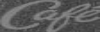

In [153]:
sample_img = customdata.__getitem__(20)[0]
tr = T.ToPILImage()
img = tr(sample_img)
img # not img.show()

In [154]:
sample_label = customdata.__getitem__(20)[1]; sample_label

tensor([13, 11, 16, 15])

In [155]:
len(sample_label)

4

In [156]:
torch.LongTensor([4])

tensor([4])

In [157]:
''.join(label2char[i] for i in sample_label.numpy())

'cafe'

In [158]:
customdata.__getitem__(20)[2]

tensor([4])

https://stackoverflow.com/questions/50544730/how-do-i-split-a-custom-dataset-into-training-and-test-datasets


In [159]:
from torch.utils.data.sampler import SubsetRandomSampler

batch_size = 8
validation_split = .2
shuffle_dataset = True
random_seed = 42

dataset_size = len(customdata)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset:
  np.random.seed(random_seed)
  np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

In [160]:
a = [(1,2,3),(3,4,1)]
print([a[i][1] for i in range(len(a))])
max([a[i][1] for i in range(len(a))])

[2, 4]


4

in the context of PyTorch's DataLoader, batch is a list of tuples like [(image1, target1, target_length1), (image2, target2, target_length2), ...]

In [161]:
from torch.nn.utils.rnn import pad_sequence

def collate_fn(data):
  """
    data: (image, label_list, label) from __getitem__
  """
  images, label_lists, lengths = zip(*data)
  # print(type(images)) - tuple
  # max_len = max([data[i][1] for i in range(len(data))]) - manual padding here can be done with rnn.pad_sequence

  labels_padded = pad_sequence([torch.tensor(label) for label in label_lists], batch_first=True, padding_value=0)
  # print(labels_padded)
  # print(lengths)
  return torch.stack(images), labels_padded, torch.tensor(lengths)

In [162]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(customdata, batch_size=batch_size, sampler=train_sampler, collate_fn = collate_fn)
test_dataloader = DataLoader(customdata, batch_size=batch_size, sampler=valid_sampler, collate_fn = collate_fn)

In [163]:
for d, l, _ in train_dataloader:
  print(d.size()) # (N, C, H, W)
  # print(d)
  break

torch.Size([8, 1, 32, 100])


<ipython-input-161-d9c2bf55200e>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_padded = pad_sequence([torch.tensor(label) for label in label_lists], batch_first=True, padding_value=0)


RuntimeError: each element in list of batch should be of equal size; NEED A COLLATE FUNCTION

https://discuss.pytorch.org/t/runtimeerror-each-element-in-list-of-batch-should-be-of-equal-size-image-caption-generator-kaggle/100586

sample_img.shape: torch.Size([1, 32, 100])
sample_img_transposed.shape: (32, 100, 1)
conv2d'd sample_img.shape: torch.Size([3, 33, 101])
(33, 101, 3)


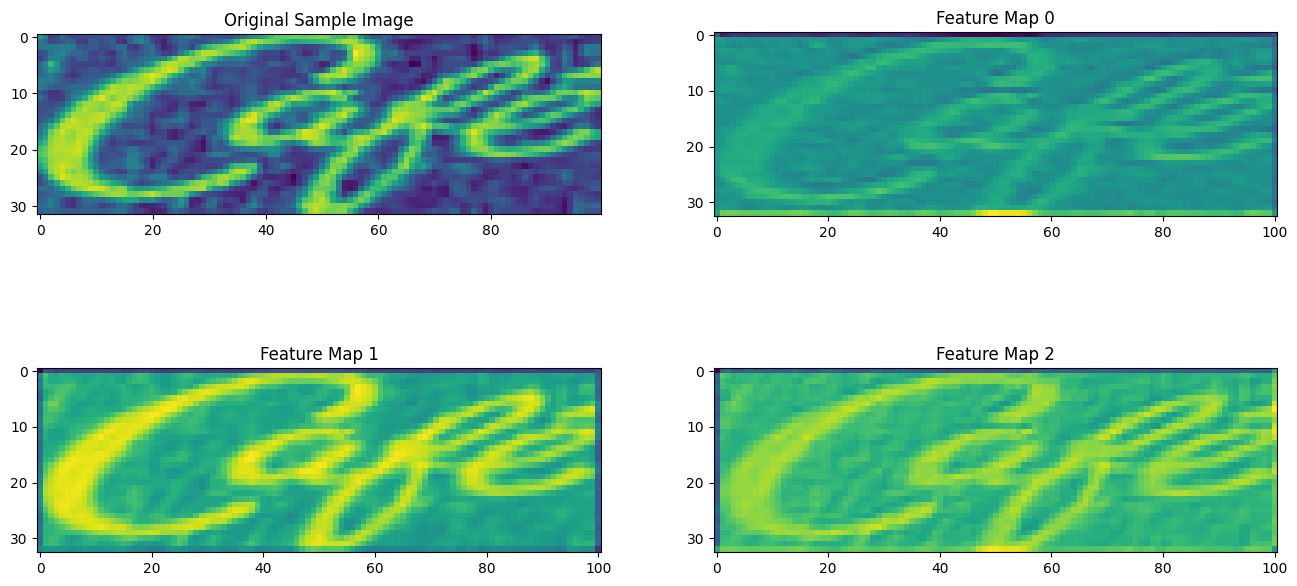

In [164]:
from torch import nn

sample_img_transposed = np.asarray(sample_img).transpose(1,2,0)
print(f'sample_img.shape: {sample_img.shape}')
print(f'sample_img_transposed.shape: {sample_img_transposed.shape}')

conv2 = nn.Conv2d(in_channels=1, out_channels=3, kernel_size=(2,2), stride=1, padding=1)
print(f'conv2d\'d sample_img.shape: {conv2(sample_img).shape}')
img = conv2(sample_img).permute(1,2,0)
result = img.data.numpy()
print(result.shape) # (33, 101, 3)

max_ = np.max(result)
min_ = np.min(result)
result -= min_
result /= max_

plt.figure(figsize=(16,8))
plt.subplot(2,2,1)
plt.imshow(sample_img_transposed)
plt.title('Original Sample Image')
for i in range(3):
  plt.subplot(2,2,i+2)
  plt.imshow(result[:,:,i])
  plt.title(f'Feature Map {i}')

plt.show()

The paper's configuration seems to omit the activation layer part from its model configuration figure, [the cited VGG paper](https://arxiv.org/pdf/1409.1556.pdf) said "the relu activation function is not shown for brevity", but as it's typically known to put the activation after each convolutional layer and before pooling layers, so I'd do the same thing.

https://stackoverflow.com/questions/35543428/activation-function-after-pooling-layer-or-convolutional-layer


Seems like the order doesn't matter between pooling and activation

In [165]:
from torch import nn
import torch.nn.functional as F

class VGG(nn.Module):
  def __init__(self, train=True):
    super().__init__()
    # torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros', device=None, dtype=None)
    # output is (C, H, W)
    self.conv1 = nn.Conv2d(1, 64, 3 ,1,1)
    self.maxpool1 = nn.MaxPool2d((2,2),2)
    self.conv2 = nn.Conv2d(64, 128, 3, 1, 1)
    self.maxpool2 = nn.MaxPool2d((2,2), 2)
    self.conv3 = nn.Conv2d(128, 256, 3, 1, 1)
    self.conv4 = nn.Conv2d(256, 256, 3, 1, 1)
    self.maxpool3 = nn.MaxPool2d((2,1), 2) # (2,1) NOT (1,2)!!
    self.conv5 = nn.Conv2d(256, 512, 3, 1, 1)
    self.bn1 = nn.BatchNorm2d(512)
    self.conv6 = nn.Conv2d(512, 512, 3, 1, 1)
    self.bn2 = nn.BatchNorm2d(512)
    # the rectangular pooling windows instead of the conventional squared ones yield feature maps with larger width, hence longer feature sequence
    self.maxpool4 = nn.MaxPool2d((2,1), 2)
    self.conv7 = nn.Conv2d(512, 512, (2, 2), 1, 0)


  def forward(self, x):
    assert x.shape[2] == 32

    x = F.relu(self.conv1(x))
    x = self.maxpool1(x)
    x = F.relu(self.conv2(x))
    x = self.maxpool2(x)
    x = F.relu(self.conv3(x))
    x = F.relu(self.conv4(x))
    x = self.maxpool3(x)
    x = F.relu(self.conv5(x))
    x = self.bn1(x)
    x = F.relu(self.conv6(x))
    x = self.bn2(x)
    x = self.maxpool4(x)
    x = F.relu(self.conv7(x))
    return x

In [166]:
# need to recap about batch normalization,
# we don't do batch normalization during testing, but only for training, but simply put it does normalizing (X-u)/σ

In [167]:
vgg = VGG()

In [168]:
img_t = customdata.__getitem__(20)[0]

In [169]:
img_t_unsqueezed = img_t.unsqueeze(0)
img_t_unsqueezed.shape

torch.Size([1, 1, 32, 100])

In [170]:
result = vgg(img_t_unsqueezed)
b, c, h, w = result.size(); (b, c, h, w)

(1, 512, 1, 6)

In [171]:
result.view(b, c*h, w).permute(2,0,1).size()

torch.Size([6, 1, 512])

In [172]:
vgg(img_t_unsqueezed).shape # [batch_size, channels, height, width]

torch.Size([1, 512, 1, 6])

In [173]:
class CRNN(nn.Module):
  def __init__(self):
    super().__init__()
    self.vgg = VGG()
    self.map_to_seq = nn.Linear(512, 512) # just a linear operation to flatten the feature map to put in lstm
    self.blstm1 = nn.LSTM(512, 256, bidirectional=True)
    self.blstm2 = nn.LSTM(512, 256, bidirectional=True)
    self.fc = nn.Linear(512, len(chars)+1) # need to +1 right? cause we're implicitly assigning blank as 0 index

  def forward(self, x):
    vgg_output = self.vgg(x)
    b, c, h, w = vgg_output.size()
    vgg_output = vgg_output.view(b, c*h, w)
    vgg_output = vgg_output.permute(2,0,1) # (width, batch, feature)
    # vgg_output = vgg_output.squeeze(2) # [batch_size, channels, width]
    # vgg_output = vgg_output.permute(0, 2, 1) # [batch_size, width, channels]
    seq = self.map_to_seq(vgg_output)
    lstm_output, state = self.blstm1(seq)
    lstm_output, state = self.blstm2(lstm_output) # state = (h_n, c_n)
    logits = self.fc(lstm_output)

    return logits # (seq_len, b, num_class)

https://www.codingninjas.com/studio/library/lstms-and-bi-lstm-in-pytorch

In [174]:
crnn = CRNN()
crnn(img_t_unsqueezed).shape

torch.Size([6, 1, 69])

In [175]:
from torch import optim

def train_model(model, train_dataloader, epochs=10, learning_rate=0.9):
  criterion = nn.CTCLoss(blank=0, zero_infinity=True)
  # optimizer = optim.Adadelta(model.parameters(), lr=learning_rate)
  optimizer = optim.SGD(model.parameters(), lr=0.0003)


  for epoch in range(epochs):
    model.train()
    for batch, (images, labels, lengths) in enumerate(train_dataloader):
      # print(labels)
      torch.autograd.set_detect_anomaly(True)

      batch_size = images.size(0)
      images = images.to(device)
      logits = model(images)
      log_probs = F.log_softmax(logits, dim=2)

      input_lengths = torch.LongTensor([logits.size(0)]*batch_size) ##
      target_lengths = torch.flatten(lengths)
      # label_lengths = torch.tensor([len(label) for label in labels])
      # labels = torch.tensor([label for sublist in labels for label in sublist])
      # labels = torch.cat(labels)
      # logits_lengths = torch.full(size=(logits.size(1),), fill_value=logits.size(0), dtype=torch.long)

      # print(f'logits.shape: {logits.shape}')
      # print(f'labels.shape: {labels.shape}')
      # print(f'logits_lengths: {logits_lengths}')
      # print(f'label_lengths: {label_lengths}')
      loss = criterion(log_probs, labels, input_lengths, target_lengths)

      optimizer.zero_grad()
      loss.backward()
      torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
      optimizer.step()

      if batch % 10 == 0:
        print(f'Epoch {epoch}, Batch {batch}, Loss: {loss.item()}')

  print("Training complete!")


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CRNN().to(device)
train_model(model, train_dataloader)

<ipython-input-161-d9c2bf55200e>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_padded = pad_sequence([torch.tensor(label) for label in label_lists], batch_first=True, padding_value=0)


Epoch 0, Batch 0, Loss: 3.395650863647461
Epoch 0, Batch 10, Loss: 4.315207004547119
Epoch 1, Batch 0, Loss: 3.8037221431732178
Epoch 1, Batch 10, Loss: 4.588732719421387
Epoch 2, Batch 0, Loss: 3.5822808742523193
Epoch 2, Batch 10, Loss: 4.142555236816406
Epoch 3, Batch 0, Loss: 2.9217753410339355
Epoch 3, Batch 10, Loss: 4.2807722091674805
Epoch 4, Batch 0, Loss: 4.442739963531494
Epoch 4, Batch 10, Loss: 5.02040958404541
Epoch 5, Batch 0, Loss: 2.927781105041504
Epoch 5, Batch 10, Loss: 4.440319061279297
Epoch 6, Batch 0, Loss: 4.181015491485596
Epoch 6, Batch 10, Loss: 5.1374077796936035
Epoch 7, Batch 0, Loss: 3.7026562690734863
Epoch 7, Batch 10, Loss: 5.0635271072387695
Epoch 8, Batch 0, Loss: 3.314645767211914
Epoch 8, Batch 10, Loss: 4.60145902633667
Epoch 9, Batch 0, Loss: 4.244434356689453
Epoch 9, Batch 10, Loss: 4.795269966125488
Training complete!
